In [1]:
import cv2
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#combine the same fold train and test sets to examine full dataset
paths = ['/content/drive/MyDrive/openface_test_task/Classification/NNEW_trainval_0.txt', 
         '/content/drive/MyDrive/openface_test_task/Classification/NNEW_test_0.txt'] 

img_filenames = []
labels = []
lesions = []
for anotation_filepath in paths:
    fp = open(anotation_filepath, 'r')
    for line in fp.readlines():
        filename, label, lesion = line.split()
        img_filenames.append(filename)
        labels.append(int(label))
        lesions.append(int(lesion))
    fp.close()

In [3]:
#obtain image size parameters
img_path = '/content/drive/MyDrive/openface_test_task/Classification/JPEGImages/'

img_width = []
img_height = []

def get_img_size(img_path, img_fimename):
    img = Image.open(os.path.join(img_path, img_filename))
    width, height = img.size
    return width, height

for img_filename in img_filenames:
    width, height = get_img_size(img_path, img_filename)
    img_width.append(width)
    img_height.append(height)

In [4]:
import pandas as pd

img_params_df = pd.DataFrame({'filename':img_filenames, 
                              'height':img_height, 
                              'width': img_width, 
                              'lesions': lesions,
                              'labels': labels})
# img_params_df.head()

### Take a look on the data

In [7]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [5]:
import xml.etree.ElementTree as ET

annot_path = '/content/drive/MyDrive/openface_test_task/Detection/VOC2007/Annotations/'

def get_annotation(xml_file):

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        dict_with_single_boxes = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
        list_with_all_boxes.append(dict_with_single_boxes)

    return list_with_all_boxes

def get_boxes_size(annot_path, filename):
    heights = []
    widths = []
    areas = []
    filename, _ = os.path.splitext(filename)
    annotation_boxes = get_annotation(os.path.join(annot_path, filename + '.xml'))    
    for box in annotation_boxes:
        height = box['ymax'] - box['ymin']
        width = box['xmax'] - box['xmin']
        area = height * width
        heights.append(height)
        widths.append(width)
        areas.append(area)
    return heights, widths, areas

def plot_class_samples(class_label, nrows, ncols):
    fig, ax = plt.subplots(5, 10, figsize=(20, 17))

    for i in range(nrows):
        for j in range(ncols):
            severity_df = img_params_df[img_params_df.labels == class_label].reset_index(drop=True)
    #         print(severity_df.filename)
            instance = os.path.splitext(severity_df.filename[i*10 + j])
            img = Image.open(os.path.join(img_path, severity_df.filename[i*10 + j]))
            annotation_boxes = get_annotation(os.path.join(annot_path, instance[0] + '.xml'))
            for box in annotation_boxes:
                x, y = box['xmin'], box['ymin']
                w = box['xmax'] - box['xmin']
                h = box['ymax'] - box['ymin']
                ax[i, j].add_patch(matplotlib.patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=1))
            ax[i, j].imshow(img)
#             ax[i, j].set_xlabel('Severity level ' + str(i))
#             ax[i, j].axis('off')
    plt.show()

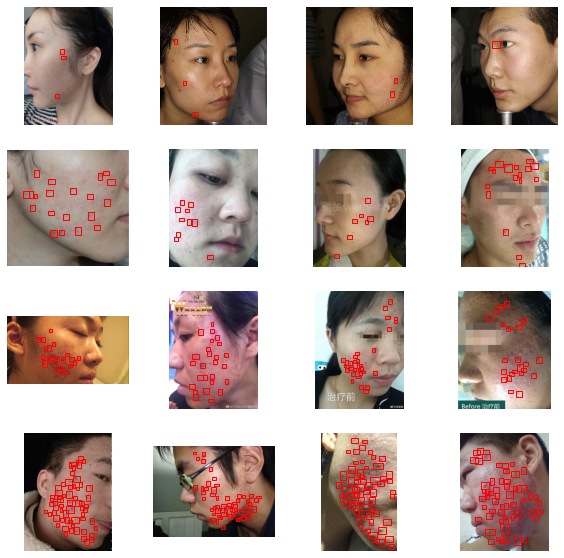

In [8]:
# sample several images with annotation boxes from each class in order to better understand data we are working with
fig, ax = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        severity_df = img_params_df[img_params_df.labels == i].reset_index(drop=True)
        instance = os.path.splitext(severity_df.filename[j])
        img = Image.open(os.path.join(img_path, severity_df.filename[j]))
        annotation_boxes = get_annotation(os.path.join(annot_path, instance[0] + '.xml'))
        for box in annotation_boxes:
            x, y = box['xmin'], box['ymin']
            w = box['xmax'] - box['xmin']
            h = box['ymax'] - box['ymin']
            ax[i, j].add_patch(matplotlib.patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=1))
        ax[i, j].imshow(img)
        ax[i, j].set_xlabel('Severity level ' + str(i))
        ax[i, j].axis('off')
plt.show()

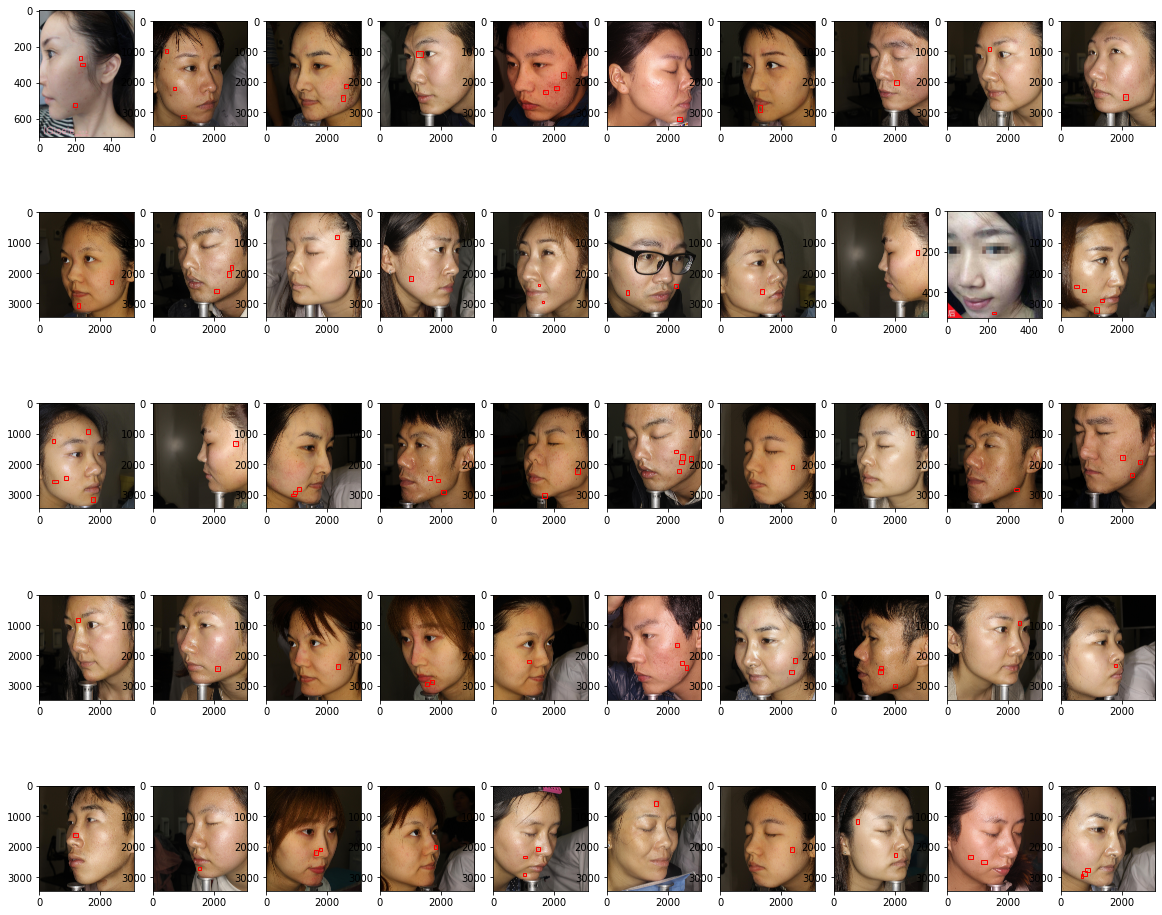

In [ ]:
plot_class_samples(0, 5, 10)

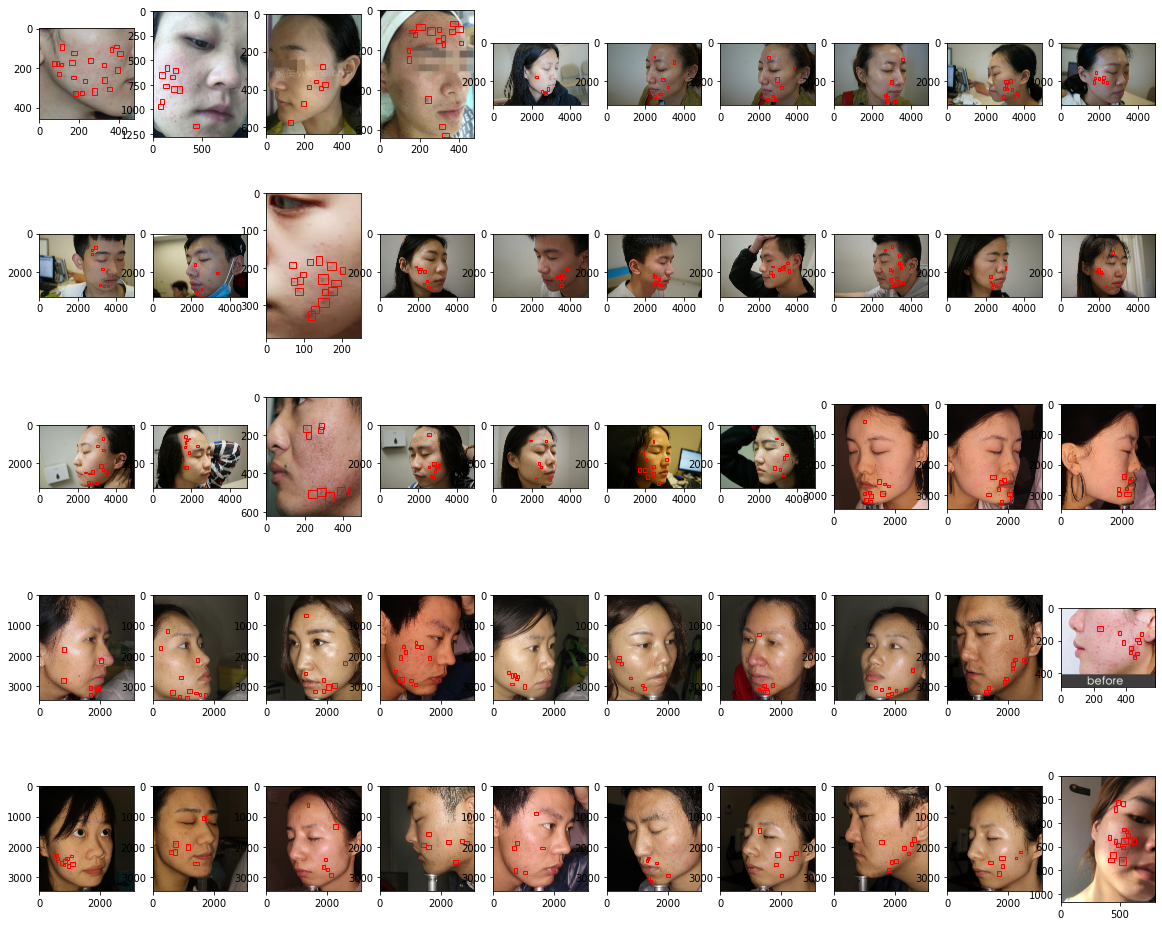

In [ ]:
plot_class_samples(1, 5, 10)

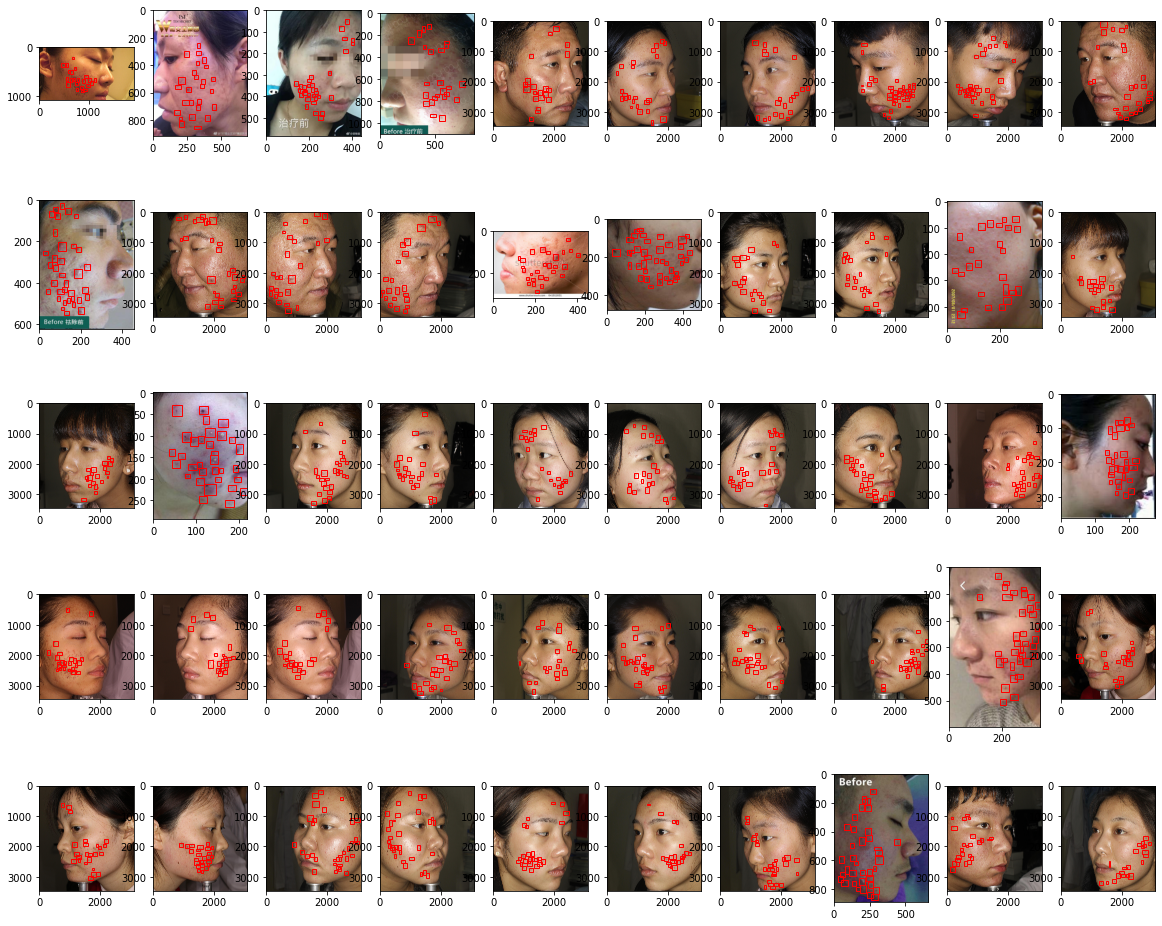

In [ ]:
plot_class_samples(2, 5, 10)

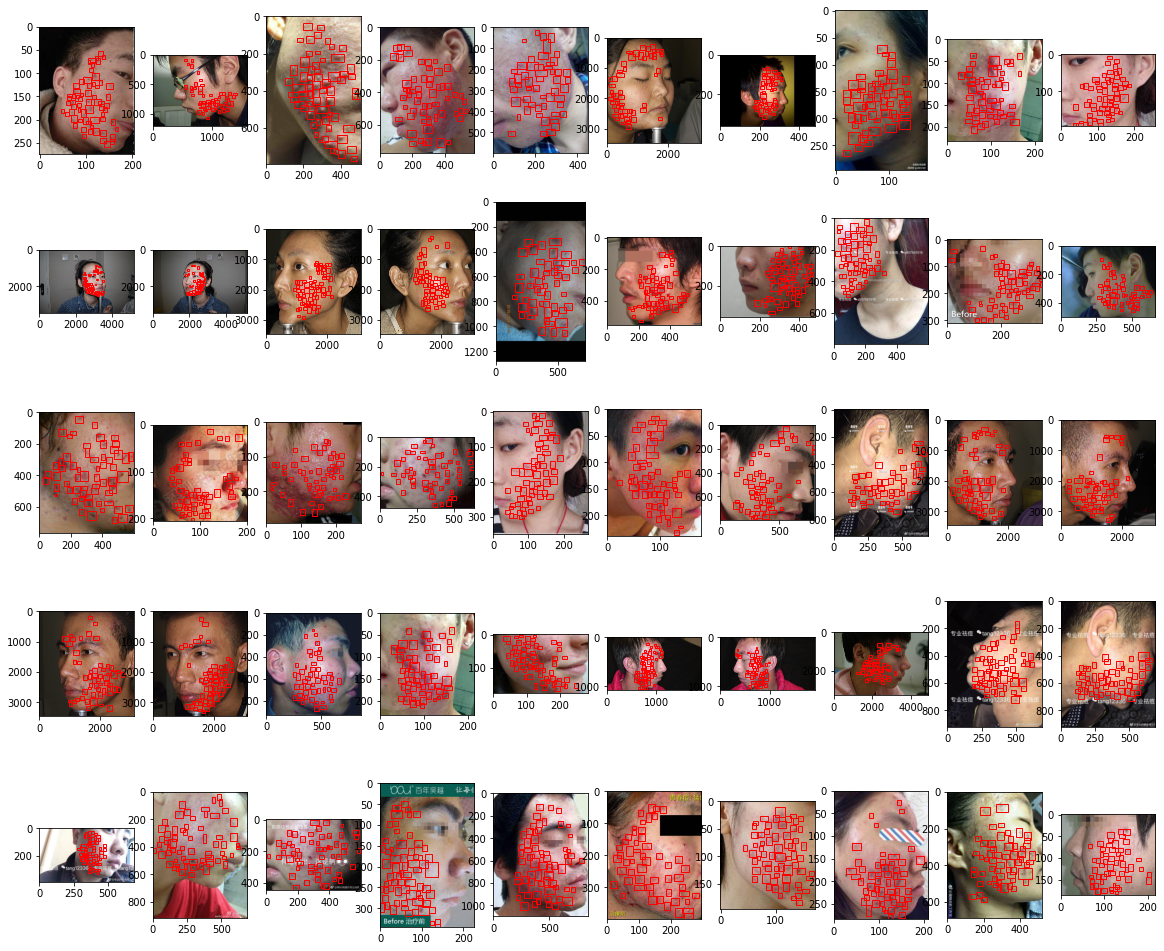

In [ ]:
plot_class_samples(3, 5, 10)

In [ ]:
# class distribution
img_params_df.labels.value_counts()

1    633
0    513
2    182
3    129
Name: labels, dtype: int64

### Distributions of image dimensions

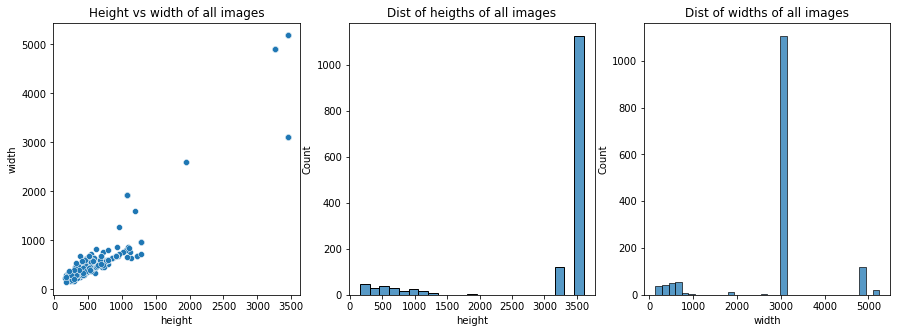

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(data=img_params_df, x='height', y='width', ax=axes[0])
sns.histplot(data=img_params_df, x='height', binwidth=150, ax=axes[1])
sns.histplot(data=img_params_df, x='width', binwidth=150, ax=axes[2])

axes[0].set_title('Height vs width of all images')
axes[1].set_title('Dist of heigths of all images')
axes[2].set_title('Dist of widths of all images')

plt.show()

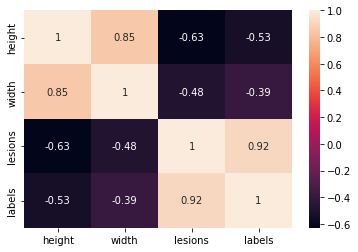

In [10]:
corr = img_params_df.corr()
sns.heatmap(corr, 
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

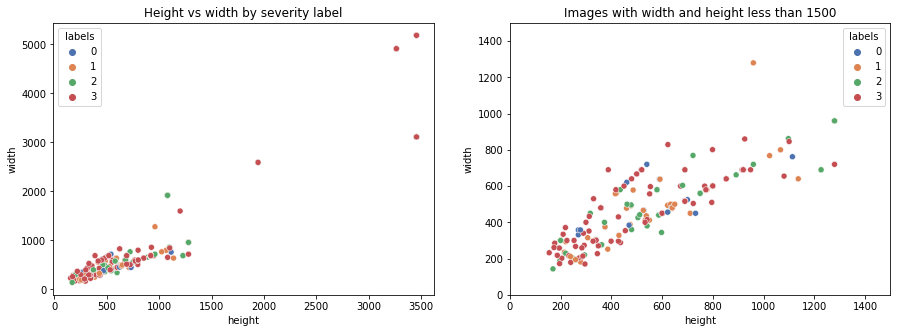

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.scatterplot(data=img_params_df, x='height', y='width', hue='labels', palette="deep", ax=axes[0])
axes[0].set_title('Height vs width by severity label')
sns.scatterplot(data=img_params_df, x='height', y='width', hue='labels', palette="deep", ax=axes[1])
axes[1].set_title("Images with width and height less than 1500")
axes[1].set_xlim(0, 1500)
axes[1].set_ylim(0, 1500)

plt.show()

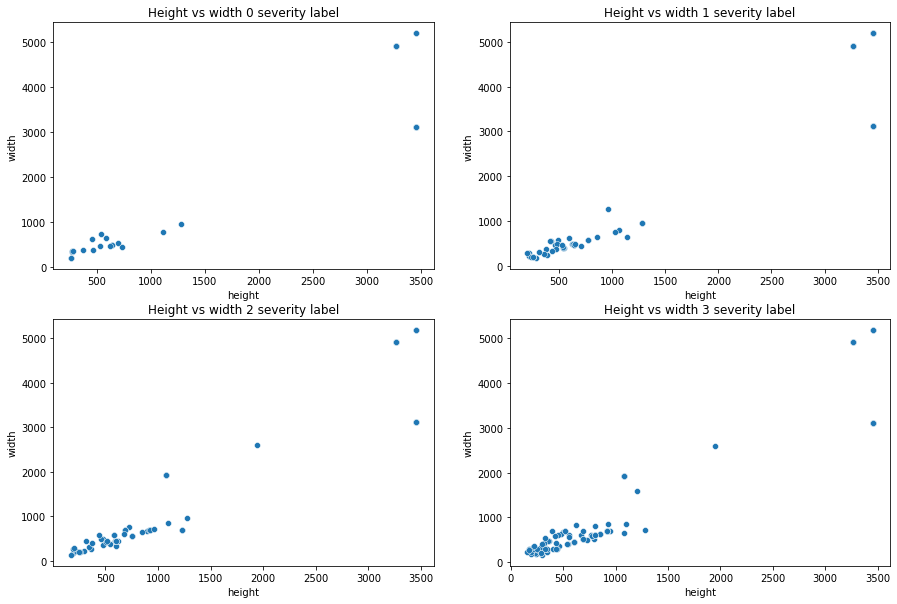

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(data=img_params_df[img_params_df.labels == 0], x='height', y='width', ax=axes[0, 0])
axes[0, 0].set_title('Height vs width 0 severity label')
sns.scatterplot(data=img_params_df[img_params_df.labels == 1], x='height', y='width', ax=axes[0, 1])
axes[0, 1].set_title('Height vs width 1 severity label')
sns.scatterplot(data=img_params_df[img_params_df.labels == 2], x='height', y='width', ax=axes[1, 0])
axes[1, 0].set_title('Height vs width 2 severity label')
sns.scatterplot(data=img_params_df[img_params_df.labels == 3], x='height', y='width', ax=axes[1, 1])
axes[1, 1].set_title('Height vs width 3 severity label')

plt.show()

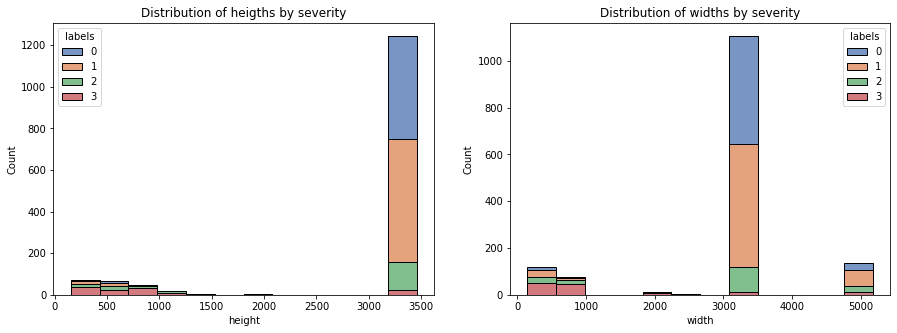

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=img_params_df, x='height', hue='labels', palette="deep", multiple='stack', ax=axes[0])
sns.histplot(data=img_params_df, x='width',hue='labels', palette="deep", multiple='stack', ax=axes[1])

axes[0].set_title('Distribution of heigths by severity')
axes[1].set_title('Distribution of widths by severity')

plt.show()

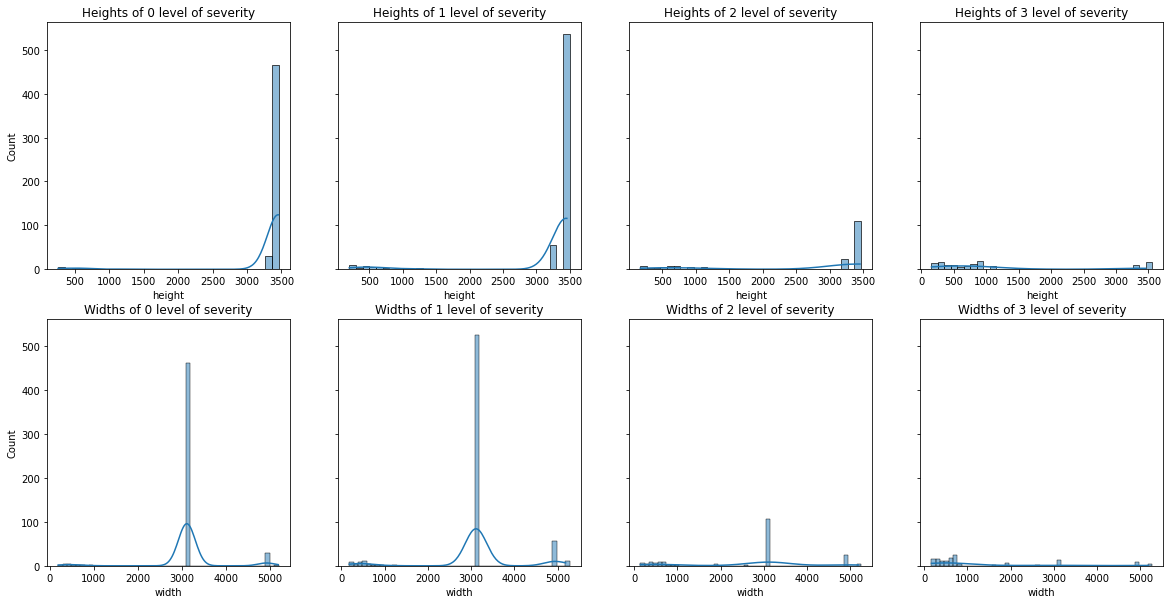

In [14]:
#zoom in to every class height and width separately 
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(20, 10))

for i in range(4):
    sns.histplot(data=img_params_df[img_params_df.labels==i], x='height', binwidth=100, kde=True, ax=axes[0, i])
    sns.histplot(data=img_params_df[img_params_df.labels==i], x='width',binwidth=100, kde=True, ax=axes[1, i])
#     sns.histplot(data=img_params_df[img_params_df.labels==i], x = 'aspect_ratio',kde=True, binwidth=0.05, ax=axes[2, i])
    
    axes[0, i].set_title('Heights of ' + str(i) + ' level of severity')
    axes[1, i].set_title('Widths of ' + str(i) + ' level of severity')
#     axes[2, i].set_title('Height vs width ratio ' + str(i) + ' level of severity')

plt.show()

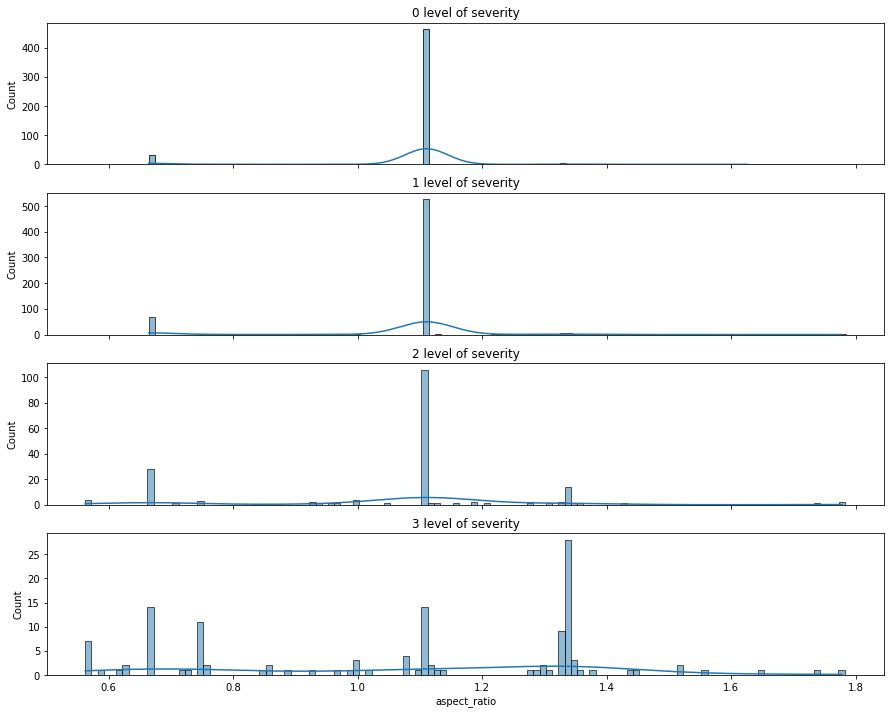

In [15]:
# aspect ratio of images
img_params_df['aspect_ratio'] = img_params_df['height'] / img_params_df['width']

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15,12))

for i in range(4):
    sns.histplot(data=img_params_df[img_params_df.labels==i], x = 'aspect_ratio', kde = True, binwidth=0.01, ax=axes[i])
    axes[i].set_title(str(i) + ' level of severity')
plt.show()


**Images summary**

It seems that the images in this dataset are collected from two sources, the first source is professional high-resolution images and the second source looks like a selfies. High resolution images are of a fixed size and the position of the head in the frame is also standard. Meanwhile "selfies" have various size and width-height ratio and faces are depicted at different angles and can be cropped in the frame. 

Subsets with acne severity level 0 and 1 have more high resolution images. Most of the 2 level severity images also have a high resolution, however, due to the small number of samples in this class, their share is significantly lower than in 0 and 1 classes. Very severy acne images are very different from each other in image size, aspect ratio, however some portion of high-resolution images are also presented. 

There are moderate correlation between image size and severity label. To process this dataset data augmentation is required, e.g some cropping or rescaling.

### Distribution of sizes of anchor boxes 

In [16]:
def get_annoation_params(annot_path, df):
    boxes_heights = []
    boxes_widths = []
    boxes_areas = []
    for filename in df.filename:
        height, width, area = get_boxes_size(annot_path, filename)
        boxes_heights.append(height)
        boxes_widths.append(width)
        boxes_areas.append(area)
   
    boxes_heights = [item for sublist in boxes_heights for item in sublist]
    boxes_widths = [item for sublist in boxes_widths for item in sublist]
    boxes_areas = [item for sublist in boxes_areas for item in sublist]
    return np.array(boxes_heights), np.array(boxes_widths), np.array(boxes_areas)


boxes_heights, boxes_widths, boxes_areas = get_annoation_params(annot_path, img_params_df)
boxes_heights_0, boxes_widths_0, boxes_areas_0 = get_annoation_params(annot_path, img_params_df[img_params_df.labels == 0])
boxes_heights_1, boxes_widths_1, boxes_areas_1 = get_annoation_params(annot_path, img_params_df[img_params_df.labels == 1])
boxes_heights_2, boxes_widths_2, boxes_areas_2 = get_annoation_params(annot_path, img_params_df[img_params_df.labels == 2])
boxes_heights_3, boxes_widths_3, boxes_areas_3 = get_annoation_params(annot_path, img_params_df[img_params_df.labels == 3])

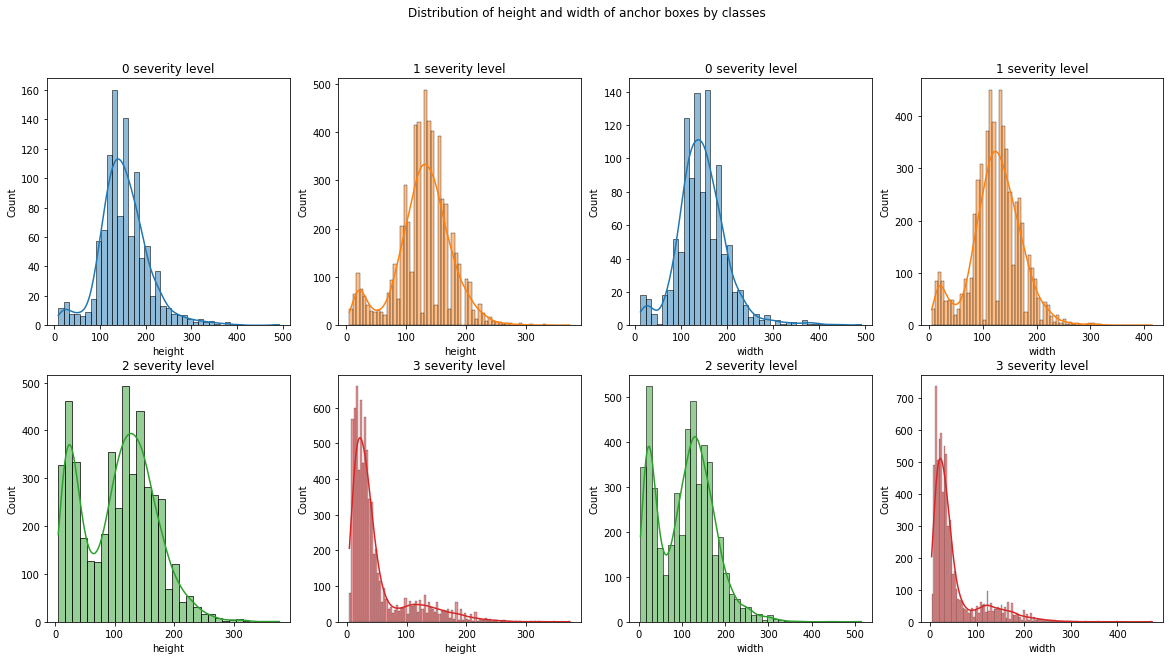

In [27]:
# aspect ratio of images
fig, axes = plt.subplots(2, 4, figsize=(20,10))

sns.histplot(boxes_heights_0, kde = True, color='tab:blue', ax=axes[0,0])
sns.histplot(boxes_heights_1, kde = True, color='tab:orange', ax=axes[0,1])
sns.histplot(boxes_heights_2, kde = True, color='tab:green', ax=axes[1, 0])
sns.histplot(boxes_heights_3, kde = True, color='tab:red', ax=axes[1, 1])
# axes[0].set_title('Anchors boxes heights distribution')

axes[0, 0].set_xlabel('height')
axes[0, 1].set_xlabel('height')
axes[1, 0].set_xlabel('height')
axes[1, 1].set_xlabel('height')

axes[0, 0].set_title('0 severity level')
axes[0, 1].set_title('1 severity level')
axes[1, 0].set_title('2 severity level')
axes[1, 1].set_title('3 severity level')


sns.histplot(boxes_widths_0, kde = True, color='tab:blue', ax=axes[0, 2])
sns.histplot(boxes_widths_1, kde = True, color='tab:orange', ax=axes[0, 3])
sns.histplot(boxes_widths_2, kde = True, color='tab:green', ax=axes[1, 2])
sns.histplot(boxes_widths_3, kde = True, color='tab:red', ax=axes[1, 3])
# axes[1].set_title('Anchors boxes widths distribution')
# axes[1].legend(labels=['0', '1', '2', '3'])
axes[0, 2].set_xlabel('width')
axes[0, 2].set_title('0 severity level')

axes[0, 3].set_xlabel('width')
axes[0, 3].set_title('1 severity level')

axes[1, 2].set_xlabel('width')
axes[1, 2].set_title('2 severity level')

axes[1, 3].set_xlabel('width')
axes[1, 3].set_title('3 severity level')

fig.suptitle('Distribution of height and width of anchor boxes by classes')
plt.show()

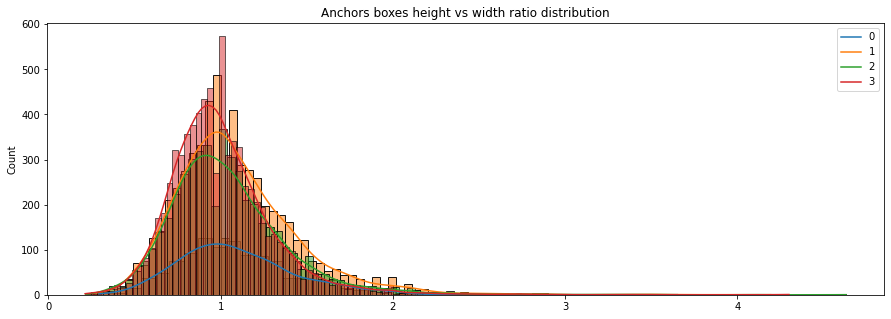

In [28]:
# aspect ratio of images
fig, axes = plt.subplots(1, 1, figsize=(15,5))

sns.histplot(boxes_heights_0 / boxes_widths_0, kde = True, color='tab:blue')
sns.histplot(boxes_heights_1 / boxes_widths_1, kde = True, color='tab:orange')
sns.histplot(boxes_heights_2 / boxes_widths_2, kde = True, color='tab:green')
sns.histplot(boxes_heights_3 / boxes_widths_3, kde = True, color='tab:red')
axes.set_title('Anchors boxes height vs width ratio distribution')
axes.legend(labels=['0', '1', '2', '3'])

plt.show()

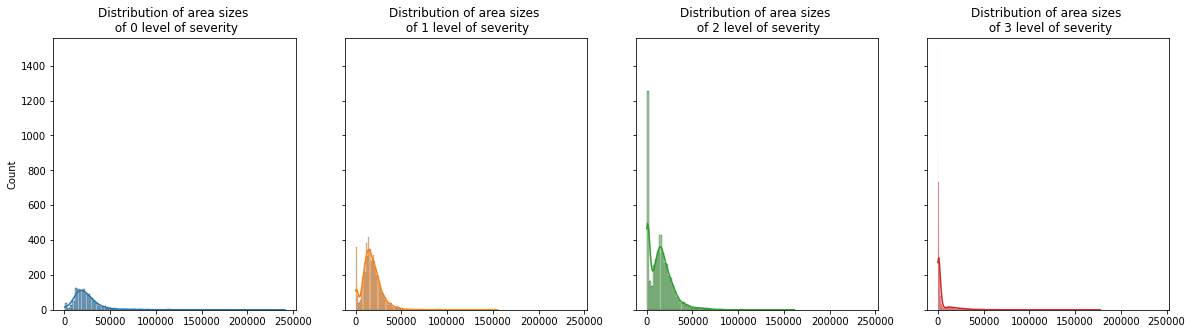

In [30]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))
sns.histplot(boxes_areas_0, kde = True, color='tab:blue',  ax=axes[0])
sns.histplot(boxes_areas_1, kde = True, color='tab:orange', ax=axes[1])
sns.histplot(boxes_areas_2, kde = True, color='tab:green', ax=axes[2])
sns.histplot(boxes_areas_3, kde = True, color='tab:red', ax=axes[3])

for i in range(4):
    axes[i].set_title('Distribution of area sizes \n of ' + str(i) + ' level of severity')

plt.show()

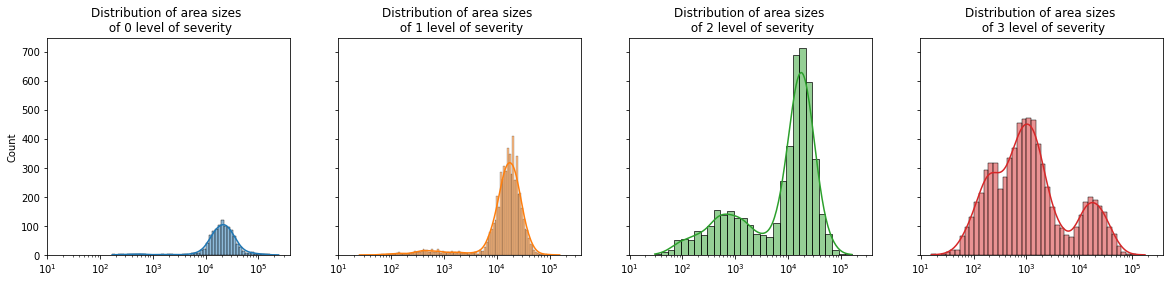

In [33]:
# the distributions of boxes areas are too wide, so switch to log scale

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 4))
sns.histplot(boxes_areas_0, kde = True, color='tab:blue', log_scale=True, ax=axes[0])
sns.histplot(boxes_areas_1, kde = True, color='tab:orange',log_scale=True, ax=axes[1])
sns.histplot(boxes_areas_2, kde = True, color='tab:green', log_scale=True, ax=axes[2])
sns.histplot(boxes_areas_3, kde = True, color='tab:red', log_scale=True, ax=axes[3])

for i in range(4):
    axes[i].set_title('Distribution of area sizes \n of ' + str(i) + ' level of severity')

plt.show()

### Size of images vs size of the annotation boxes

In [34]:
mratio = []
sratio = []

for i in range(img_params_df.shape[0]):
    filename = img_params_df.iloc[i].filename
    image_area = img_params_df.iloc[i].height * img_params_df.iloc[i].width
    _, _, area = get_boxes_size(annot_path, filename)
    
    mean_box_area = np.mean(area)
    sum_box_area = np.sum(area)
    
    mean_ratio = mean_box_area / image_area
    sum_ratio = sum_box_area / image_area
    
    mratio.append(mean_ratio)
    sratio.append(sum_ratio)
    
img_params_df['mean_box2img_ratio'] = mratio
img_params_df['sum_box2img_ratio'] = sratio

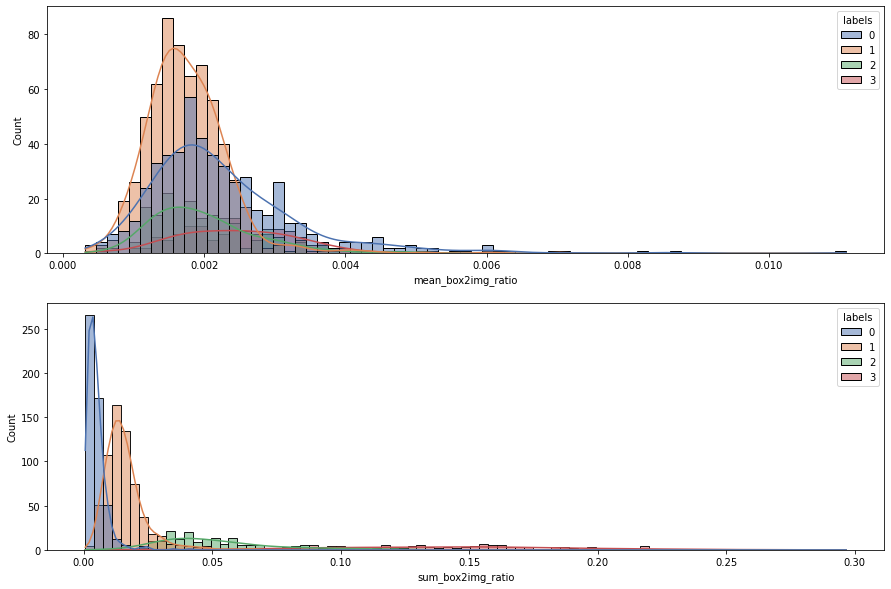

In [35]:
# aspect ratio of images
fig, axes = plt.subplots(2, 1, figsize=(15,10))

sns.histplot(data=img_params_df, x='mean_box2img_ratio', hue='labels', kde = True, palette='deep', ax=axes[0])
sns.histplot(data=img_params_df, x='sum_box2img_ratio', hue='labels', kde = True, palette='deep', ax=axes[1])

plt.show()

In [36]:
img_params_df.groupby('labels').describe(include=np.int64, percentiles=[0.5])

height                                   ...   lesions                  
        count         mean          std    min  ...       std   min   50%   max
labels                                          ...                            
0       513.0  3343.052632   536.210633  259.0  ...  1.096447   1.0   2.0   5.0
1       633.0  3251.758294   713.537211  200.0  ...  2.993624   6.0   8.0  20.0
2       182.0  2681.164835  1238.297613  170.0  ...  5.232582  21.0  25.0  42.0
3       129.0  1163.635659  1133.863197  155.0  ...  4.526663  51.0  58.0  65.0

[4 rows x 18 columns]

In [37]:
img_params_df.groupby('labels').describe(include=np.float64, percentiles=[0.5])

aspect_ratio                      ... sum_box2img_ratio                    
              count      mean       std  ...               min       50%       max
labels                                   ...                                      
0             513.0  1.083861  0.120224  ...          0.000545  0.003922  0.041249
1             633.0  1.068437  0.154451  ...          0.002231  0.014234  0.066329
2             182.0  1.053022  0.226766  ...          0.012733  0.047015  0.162896
3             129.0  1.069012  0.308372  ...          0.027792  0.143076  0.296676

[4 rows x 18 columns]

**Annotation Summary**

Annotation boxes height and width distribution are bimodal, this is explained by 'two-sourses nature" of the images. One of the distribution peaks is responsible for annotation of high-resolution images, and the second for annotation of small images. Depending on the proportion of images of each size, one peak is more or less, respectively. The same can be said about boxes areas. Annotation are tend to be square, the mean aspect ratio for all classes are close to 1. 

The ratio of the total annotation area to the image area increases with the severity of acne, while the ratio of the average annotation box size to the image size is approximately the same in each class. Ratio distributions are wider for very severe class, this indicate on heterogenity of this subsample of images.